# Test Notebook
## Play with functions and new APIs before adding them to the test lineup.

In [1]:
import matplotlib.pyplot as plt

def print_centroids(c):
    for index, image in enumerate(c):
        image = image.numpy().astype(float).reshape(64,64,3)
        image /= 255
        print(f"Centroid {index}:")
        plt.imshow(image)
        plt.show()
        
def print_centroid(c):
    image = c
    image = image.numpy().astype(float).reshape(64,64,3)
    image /= 255
    plt.imshow(image)
    plt.show()

In [5]:
import util
import tensorflow as tf

tf.random.set_seed(0)
ds = util.build_frames_dataset().map(lambda x: tf.reshape(x, [-1])).shuffle(10000)
ds_tensors = list(ds.take(10000))

15.867225074768067
11.537149810791016
11.253004169464111
10.98698387145996
10.822556686401366
10.700550746917724
10.668872261047364
10.660761833190918
10.637769985198975
10.621033668518066
10.6101655960083
10.604404830932618
10.601819610595703
10.600578308105469
10.596540069580078
10.596052837371825
10.595596981048583
10.59384651184082
10.59220485687256
10.586989974975586
10.580022239685059
10.577558422088623
10.575437831878663
10.569926071166993
10.569692993164063
10.569808197021484
[712, 606, 133, 479, 106, 1348, 178, 765, 52, 764, 372, 280, 220, 557, 839, 303, 1368, 54, 414, 450]
Centroid 0:


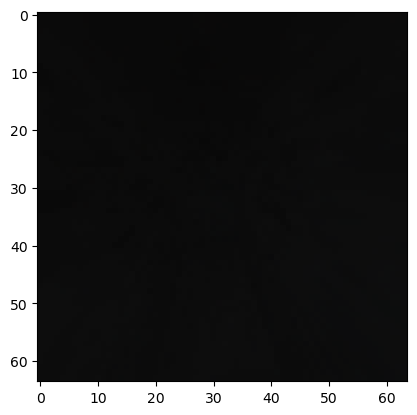

Centroid 1:


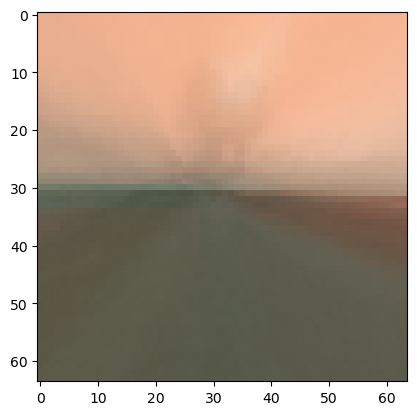

Centroid 2:


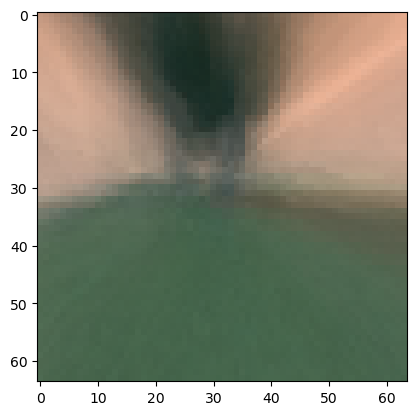

Centroid 3:


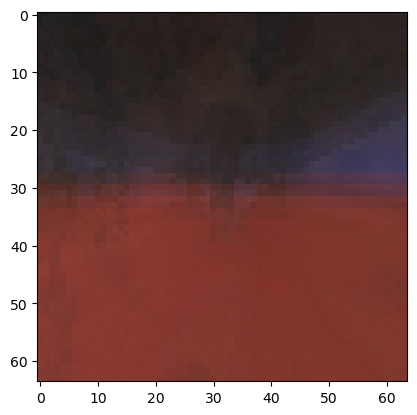

Centroid 4:


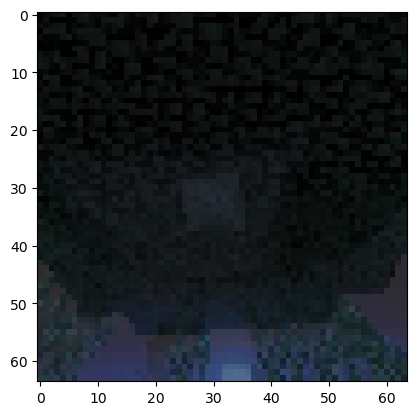

Centroid 5:


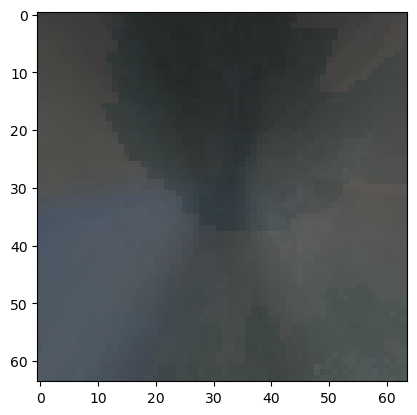

Centroid 6:


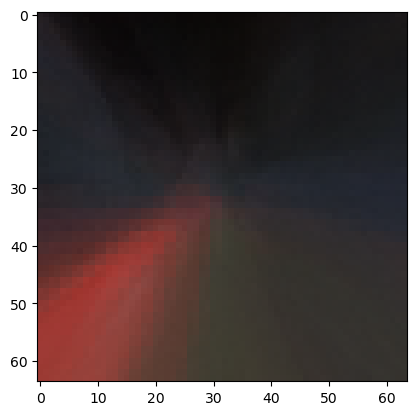

Centroid 7:


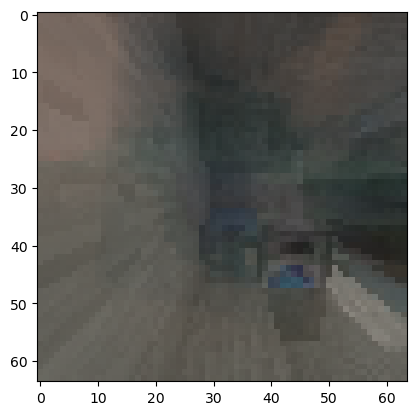

Centroid 8:


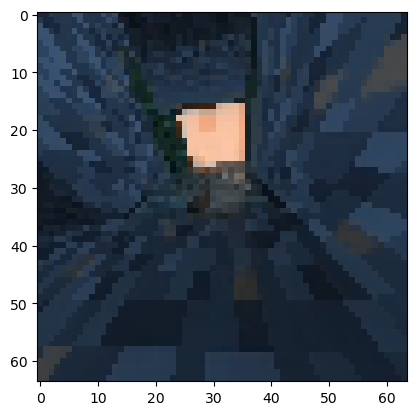

Centroid 9:


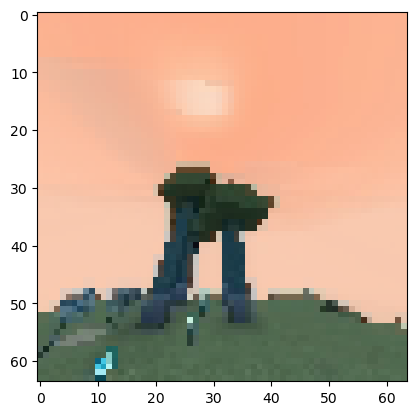

Centroid 10:


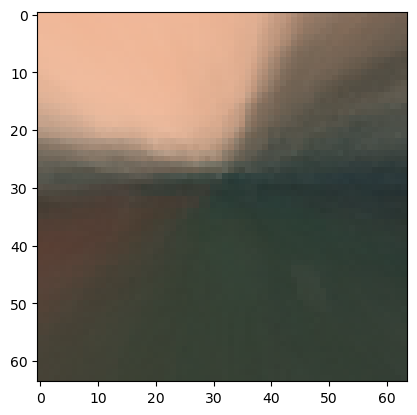

Centroid 11:


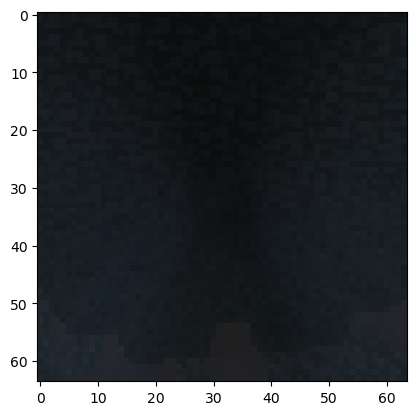

Centroid 12:


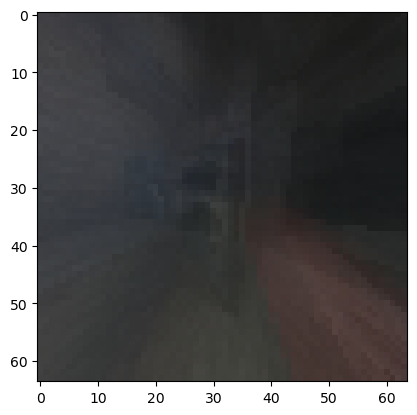

Centroid 13:


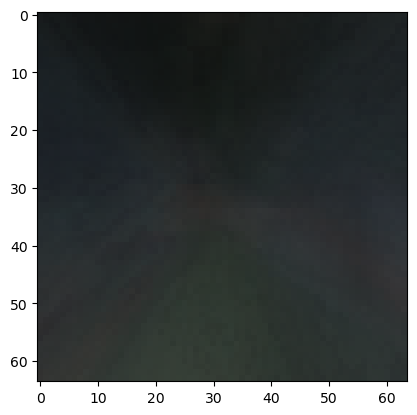

Centroid 14:


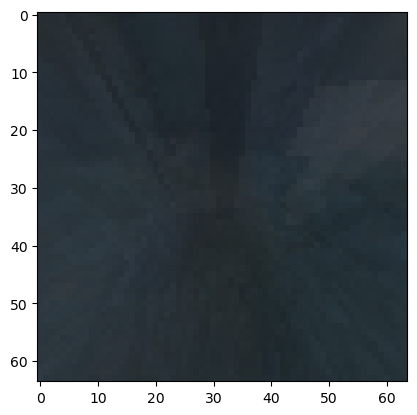

Centroid 15:


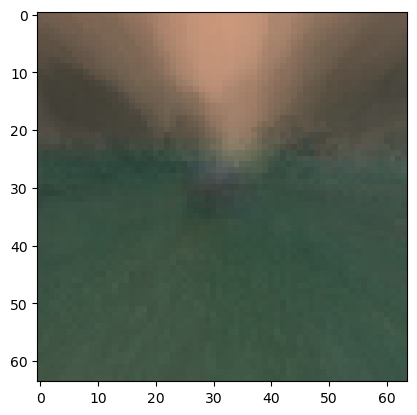

Centroid 16:


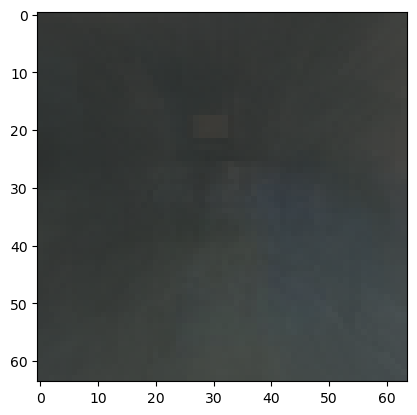

Centroid 17:


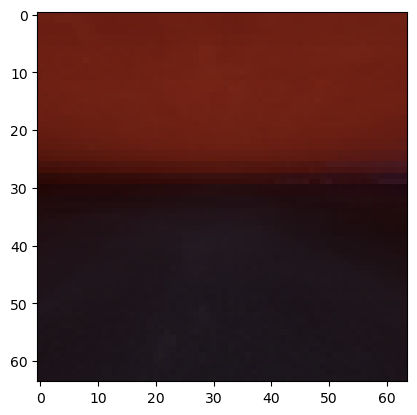

Centroid 18:


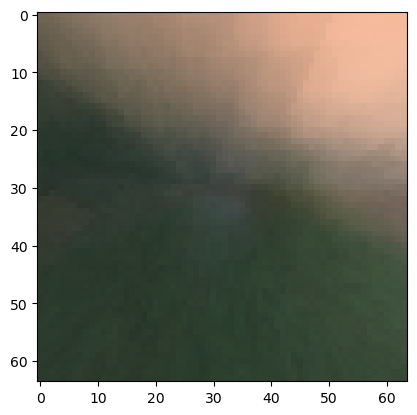

Centroid 19:


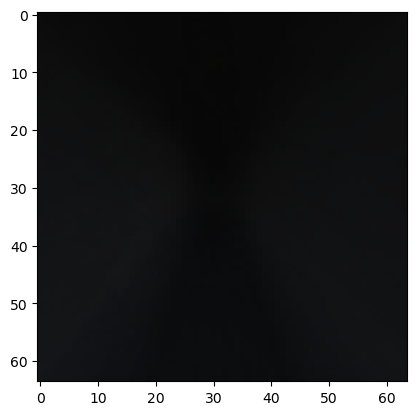

In [6]:
from clustering import kmeans
ds = tf.data.Dataset.from_tensors(ds_tensors).unbatch()
centroids = kmeans(ds, k=20, batch_size=1000, mean=128, std=255, min_inertia=0.0001)
print_centroids(centroids)